In [1]:
SingleRound <- function(sx, sy, dke, wx.dke=0.7) {
  # Computes a single decisionmaking round based on skill of decisionmaker and
  # supporter, and strength of Dunning-Kruger effect (DKE).
  #
  # Args:
  #   sx: Skill level of decisionmaker x [0, 1].
  #   sy: Skill level of supporter y [0, 1].
  #   dke: Strength of Dunning-Kruger effect [0, 1].
  #   wx.dke: Decisionmaker's perceived ability with maximum DKE. Defaults to
  #           0.7, per charts shown in Dunning and Kruger 1999.
  #
  # Returns:
  #   Logical indicating whether decision was guessed correctly.
  #
  # Define p and outcome as Bernoulli trial
  p <- runif(1)
  outcome <- as.logical(rbinom(1, 1, p))
  # Define px and py as distorted versions of p, with sx and sy indicating
  # extent of distortion (weighted average of p and random uniform noise)
  px <- (sx * p) + ((1 - sx) * runif(1))
  py <- (sy * p) + ((1 - sy) * runif(1))
  # Calculate weights wx and wy based on strength of DKE (dke), sx, and sy
  # Define d as dke * (1 - sx), which is the bias
  d <- dke * (1 - sx)
  # wx goes from wx.dke for zero-skill/max DKE, to sx for maximal skill
  wx <- (d * wx.dke) + ((1 - d) * sx)
  # wy goes from random noise for zero-skill/max DKE, to sy for maximal skill
  wy <- (d * runif(1)) + ((1 - d) * sy)
  # Predicted probability is weighted average of px and py
  pred <- ((px * wx) + (py * wy)) / (wx + wy)
  # If both weights are zero (when sx==0 & sy==0 & dke==0) set pred to avg
  if (is.na(pred)) pred <- mean(px, py)
  # Outcome is binary based on pred > 0.5
  pred.outcome <- (pred > 0.5)
  # Return whether prediction is correct
  return(outcome == pred.outcome)
}

AvgAccuracy <- function(sx, sy, dke, subrounds) {
  return(mean(sapply(seq(subrounds), function(x) SingleRound(sx, sy, dke))))
}

In [2]:
# Generate data.table with combinations of sx, sy, and dke
library(data.table)
vals <- seq(0, 1, by=0.1)
result <- data.table(expand.grid(sx=vals, sy=vals, dke=vals))

# Calculate accuracy
result[, accuracy := AvgAccuracy(sx, sy, dke, 10000), by=c("sx", "sy", "dke")]

In [3]:
result[, sx.dke := sx * dke]
result[, sy.dke := sy * dke]
result[, sx.sy := sx * sy]
result[, sx.sy.dke := sx * sy * dke]

In [4]:
summary(lm(accuracy ~ ., data=result))


Call:
lm(formula = accuracy ~ ., data = result)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07129 -0.01091  0.00048  0.01137  0.04997 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.494092   0.002978 165.887   <2e-16 ***
sx           0.293737   0.005035  58.344   <2e-16 ***
sy           0.307337   0.005035  61.046   <2e-16 ***
dke         -0.005326   0.005035  -1.058    0.290    
sx.dke      -0.002468   0.008510  -0.290    0.772    
sy.dke      -0.113918   0.008510 -13.387   <2e-16 ***
sx.sy       -0.362100   0.008510 -42.550   <2e-16 ***
sx.sy.dke    0.163868   0.014384  11.392   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0166 on 1323 degrees of freedom
Multiple R-squared:  0.9424,	Adjusted R-squared:  0.9421 
F-statistic:  3090 on 7 and 1323 DF,  p-value: < 2.2e-16


In [5]:
library(ggplot2)
library(scales)

In [6]:
my.theme <-
    theme(plot.background = element_blank(),  # Remove background
          panel.grid.major = element_blank(),  # Remove gridlines
          panel.grid.minor = element_blank(),  # Remove more gridlines
          panel.border = element_blank(),  # Remove border
          panel.background = element_blank(),  # Remove more background
          axis.ticks = element_blank(),  # Remove axis ticks
          axis.text=element_text(size=14),  # Enlarge axis text font
          axis.title=element_text(size=16),  # Enlarge axis title font
          plot.title=element_text(size=24))  # Enlarge title

In [7]:
CustomScatterPlot <- function(gg) {
    gg + geom_point() +
    stat_smooth(color="royalblue", fill="lightgray", size=1.4) +
    scale_y_continuous(labels = percent) +
    ylab("Accuracy") + my.theme
}

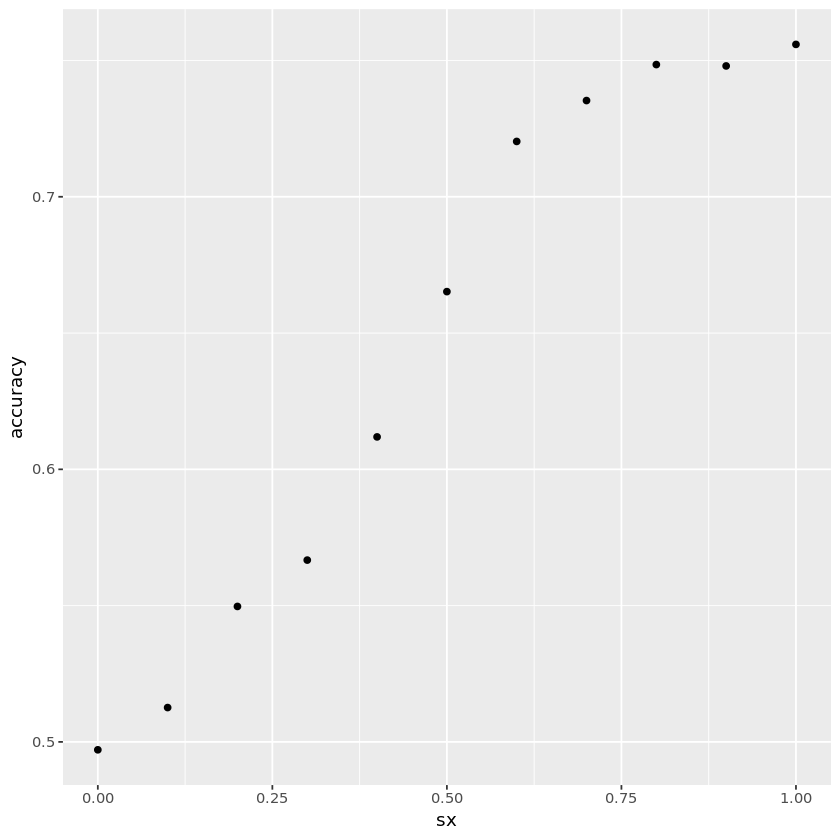

In [8]:
ggplot(result[(sy == 0) & (dke == 0)],
                         aes(sx, accuracy)) + geom_point()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


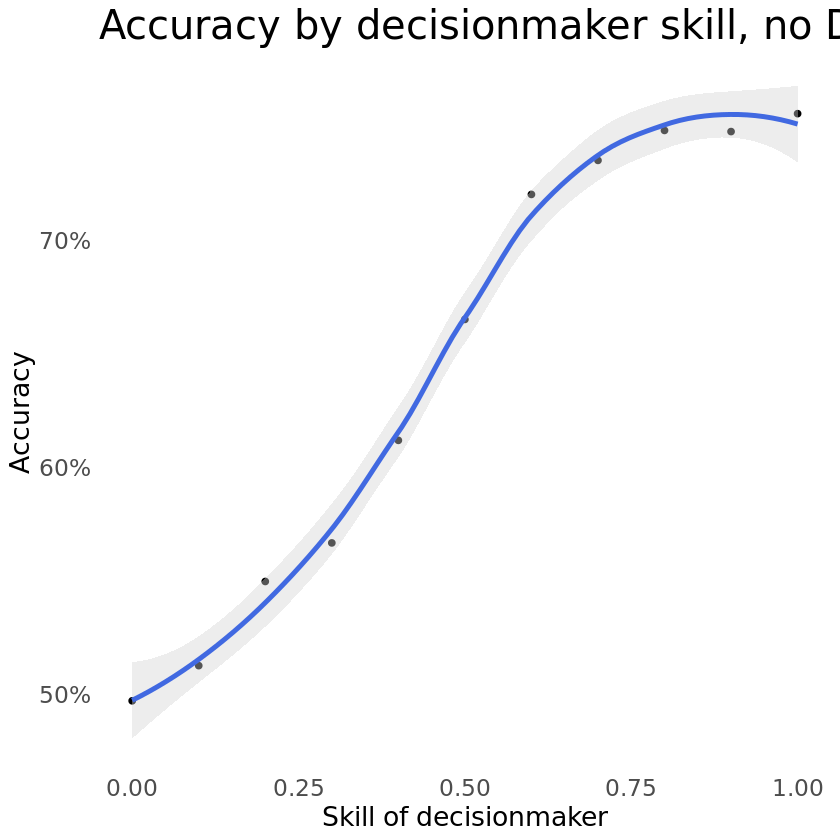

In [9]:
CustomScatterPlot(ggplot(result[(sy == 0) & (dke == 0)],
                         aes(sx, accuracy)) +
                  xlab("Skill of decisionmaker") +
                  ggtitle("Accuracy by decisionmaker skill, no DKE"))